In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
train_dir = '../dataset/Training'
test_dir = '../dataset/Testing'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
img_size = 150

In [3]:
def load_data(data_dir, categories, img_size):
    data = []
    labels = []
    for idx, category in enumerate(categories):
        folder = os.path.join(data_dir, category)
        for img_name in tqdm(os.listdir(folder), desc=f"Processing {category}"):
            img_path = os.path.join(folder, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # grayscale
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(idx)
            except:
                pass
    data = np.array(data).reshape(-1, img_size, img_size, 1) / 255.0
    labels = to_categorical(labels, num_classes=len(categories))
    return data, labels

# Load train and test datasets
X_train_full, y_train_full = load_data(train_dir, categories, img_size)
X_test, y_test = load_data(test_dir, categories, img_size)

Processing pituitary: 100%|█████████████████| 300/300 [00:00<00:00, 1492.58it/s]


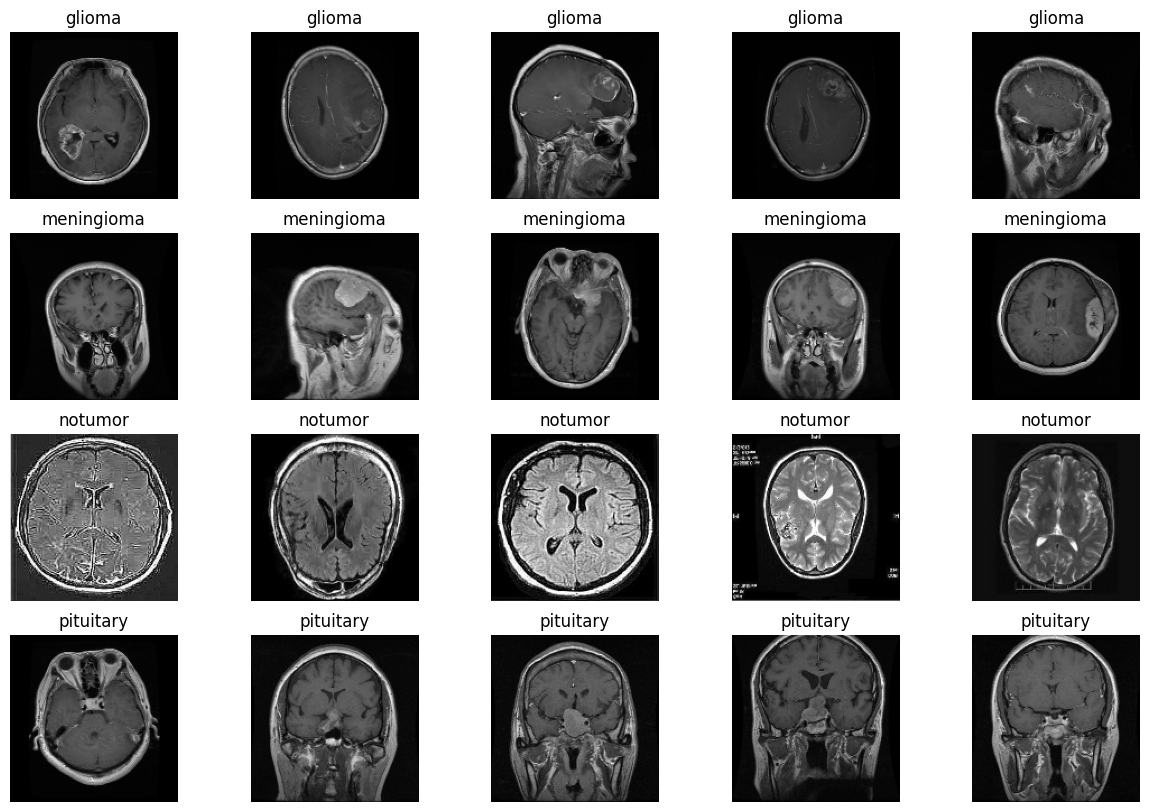

In [4]:
def plot_sample_images(X, y, categories, samples=5):
    plt.figure(figsize=(15, 10))
    for idx, category in enumerate(categories):
        imgs = X[np.argmax(y, axis=1) == idx][:samples]
        for i, img in enumerate(imgs):
            plt.subplot(len(categories), samples, idx * samples + i + 1)
            plt.imshow(img.reshape(img_size, img_size), cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.show()

plot_sample_images(X_train_full, y_train_full, categories)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [6]:
def build_vanilla_cnn():
    model = Sequential([
        Input(shape=(img_size, img_size, 1)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# VGG16 Transfer Learning (3-channel)
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs=5, model_name="model"):
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stop])

    # Plot Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.show()

    # Plot Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

    # Predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=categories))

    # Save model
    os.makedirs('../models', exist_ok=True)
    model.save(f'../models/{model_name}.keras')
    print(f"Model saved as ../models/{model_name}.keras")

    return model, (acc, prec, rec, f1)




Training Vanilla CNN...
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step - accuracy: 0.5889 - loss: 0.9704 - val_accuracy: 0.8618 - val_loss: 0.4376
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 0.8490 - loss: 0.4031 - val_accuracy: 0.8941 - val_loss: 0.3157
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 340ms/step - accuracy: 0.8961 - loss: 0.2789 - val_accuracy: 0.8933 - val_loss: 0.2823
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 362ms/step - accuracy: 0.9215 - loss: 0.2114 - val_accuracy: 0.9256 - val_loss: 0.2357
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 336ms/step - accuracy: 0.9495 - loss: 0.1507 - val_accuracy: 0.9300 - val_loss: 0.2423


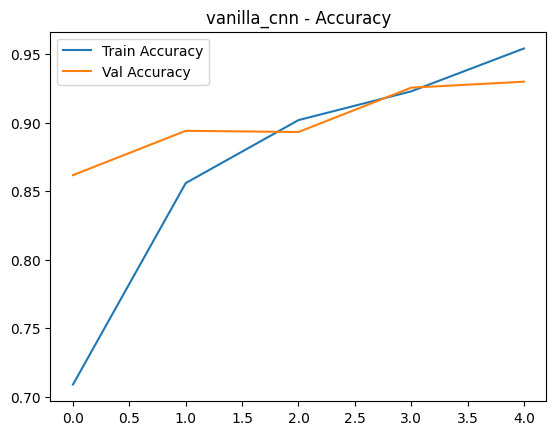

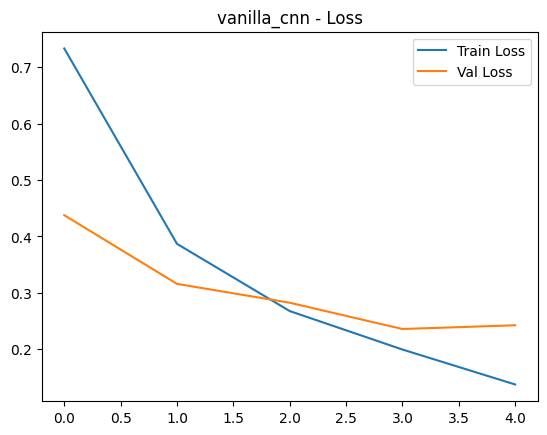

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step

vanilla_cnn Performance:
Accuracy: 0.9256, Precision: 0.9278, Recall: 0.9256, F1-Score: 0.9262

Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       288
  meningioma       0.83      0.89      0.86       265
     notumor       0.95      0.97      0.96       291
   pituitary       0.98      0.94      0.96       299

    accuracy                           0.93      1143
   macro avg       0.93      0.92      0.92      1143
weighted avg       0.93      0.93      0.93      1143

Model saved as ../models/vanilla_cnn.keras

Training VGG16 Transfer Learning...
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - accuracy: 0.5157 - loss: 1.1528 - val_accuracy: 0.8259 - val_loss: 0.5765
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.7860 - loss: 0.6070 - val_accuracy: 0.8688 - val_loss: 0.4245
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.82

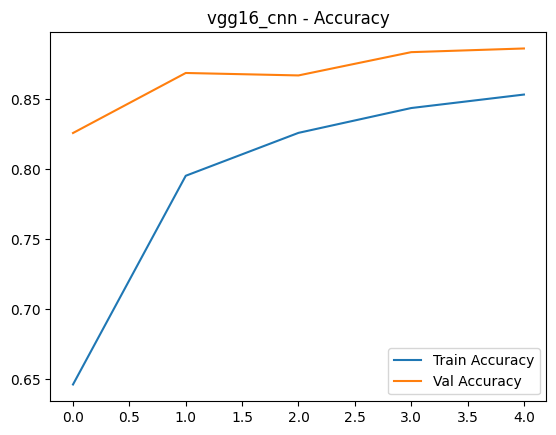

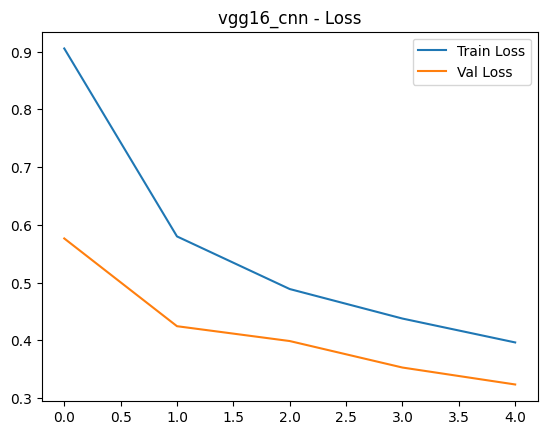

36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step

vgg16_cnn Performance:
Accuracy: 0.8863, Precision: 0.8892, Recall: 0.8863, F1-Score: 0.8870

Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.83      0.86       288
  meningioma       0.76      0.82      0.79       265
     notumor       0.97      0.95      0.96       291
   pituitary       0.92      0.94      0.93       299

    accuracy                           0.89      1143
   macro avg       0.89      0.88      0.88      1143
weighted avg       0.89      0.89      0.89      1143

Model saved as ../models/vgg16_cnn.keras


In [8]:
print("\nTraining Vanilla CNN...")
vanilla_model = build_vanilla_cnn()
vanilla_model, vanilla_metrics = train_and_evaluate(vanilla_model, X_train, y_train, X_val, y_val, epochs=5, model_name="vanilla_cnn")

# Prepare 3-channel data for VGG16 (grayscale → RGB)
X_train_vgg = np.repeat(X_train, 3, axis=-1)
X_val_vgg = np.repeat(X_val, 3, axis=-1)

print("\nTraining VGG16 Transfer Learning...")
vgg_model = build_vgg16()
vgg_model, vgg_metrics = train_and_evaluate(vgg_model, X_train_vgg, y_train, X_val_vgg, y_val, epochs=5, model_name="vgg16_cnn")


In [10]:
def predict_image(img_path, model, categories, grayscale=True, is_vgg=False):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))

    if is_vgg:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if grayscale else img
        img = np.expand_dims(img, axis=0) / 255.0
    else:
        img = img.reshape(1, img_size, img_size, 1) / 255.0

    prediction = model.predict(img)[0]
    predicted_class = np.argmax(prediction)

    plt.figure(figsize=(8,5))
    bars = plt.bar(categories, prediction, color='skyblue')
    bars[predicted_class].set_color('green')
    plt.title("Prediction Probabilities")
    plt.text(predicted_class, prediction[predicted_class]+0.02, f"Predicted: {categories[predicted_class]}", ha='center', color='green', fontweight='bold')
    plt.ylim([0,1])
    plt.show()

    print("Predicted class:", categories[predicted_class])
